In [1]:
import las2 as las
import numpy as np
import matplotlib.pyplot as plt

In [54]:
# function to read a .las file, using the las2 package:
# returns a dictionary where the keys are log's names and values are arrays
def read_well(well_path):
    data = las.read(well_path)
    for i in range(len(data['curve'])):
        if data['curve'][i]['mnemonic'] == 'DEPTH':
            depth = data['data'][i]
        elif data['curve'][i]['mnemonic'] == 'GR':
            gr = data['data'][i]
        elif data['curve'][i]['mnemonic'] == 'NPHI':
            nphi = data['data'][i]
        elif data['curve'][i]['mnemonic'] == 'RHOB':
            rhob = data['data'][i]
            
    curves = {'Depth': depth,
              'GR': gr,
              'NPHI': nphi,
              'RHOB': rhob}
    return curves

In [55]:
#reading the .las file
well_path = "../data/7-MP-28D-BA.las"
data = read_well(well_path)

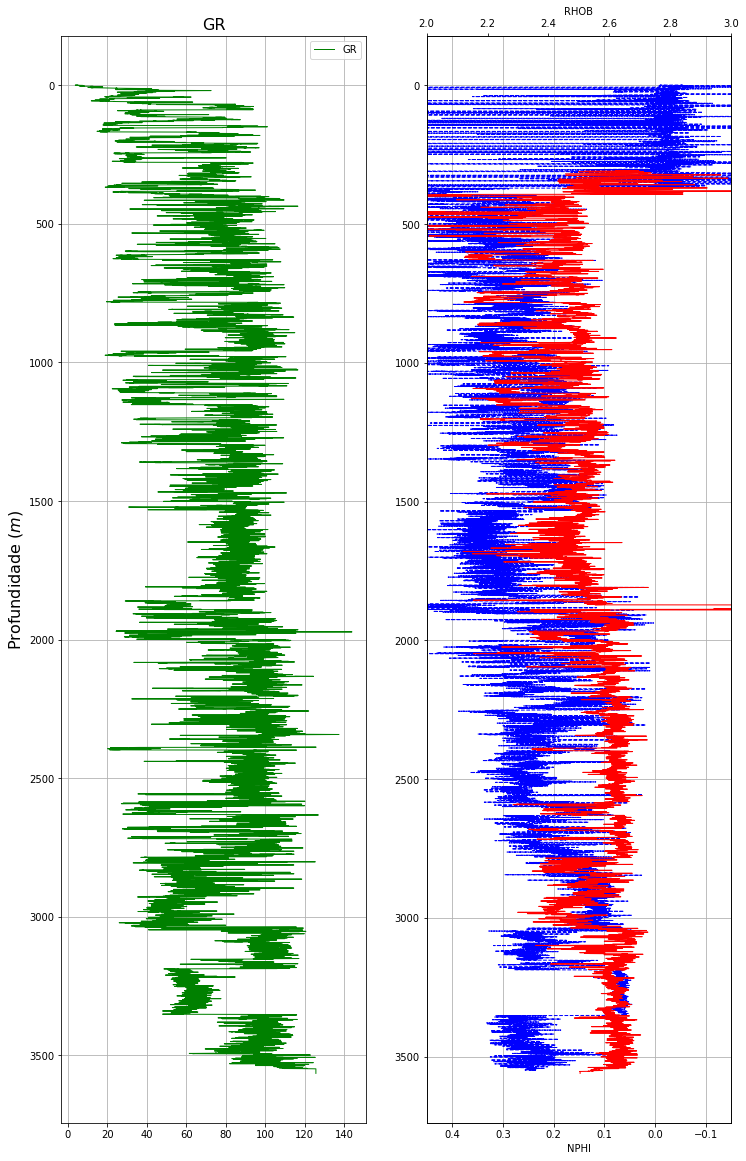

In [4]:
### Plots

fig, (ax1, ax2) = plt.subplots(1,2) # 2 tracks
fig.set_size_inches(12, 20) # Figure size | inches

#_____________________________________________________#
####GR####
ax1.plot(data['GR'],data['Depth'],'-g',linewidth = 1,label='GR')
ax2.set_xlim([0.0, 150.0])
ax1.set_ylabel('Profundidade ($m$)', fontsize=16)
ax1.set_title('GR', fontsize=16)
ax1.invert_yaxis()
ax1.grid()
ax1.legend()

#_____________________________________________________#
####NPHI####
ax2.plot(data['NPHI'], data['Depth'],'--b',linewidth = 1,label='NPHI')
ax2.set_xlim([0.45, -0.15])
ax2.set_xlabel('NPHI')
ax2.invert_yaxis()
ax2.grid()
ax2.set_xlabel('NPHI')
#ax2.set_title('RHOB / NPHI', fontsize=16)

#_____________________________________________________#
####RHOB####
ax3 = ax2.twiny() #share y axe
ax3.plot(data['RHOB'], data['Depth'],'-r',linewidth = 1,label='RHOB')
ax3.set_xlim([2.0, 3.0])
ax3.set_xlabel('RHOB')

plt.show()

## Cálculo do DRDN para interpretar a Litologia

In [5]:
# fuction to calculate the DRDN curve
def drdn_log (rhob, nphi):
    drdn = ((rhob-2)/0.05) - ((0.45 - nphi)/0.03)
    return drdn

In [56]:
#calculating the DRDN curve
drdn = drdn_log(data['RHOB'], data['NPHI'])
data['DRDN'] = drdn

In [57]:
lit_py = np.full(len(data['DRDN']), np.nan)

# using the DRDN curve to interpret lithology 
for i in range(len(data['DRDN'])):
    if data['DRDN'][i] < -1.0000:
        lit_py[i] = 49.000
        
    if data['DRDN'][i] >= -1.0000 and data['DRDN'][i] < -0.3000 :
        lit_py[i] = 25.000
        
    if data['DRDN'][i] >= -0.3000 and data['DRDN'][i] < 0.3000 :
        lit_py[i] = 54.000
        
    if data['DRDN'][i] >= 0.3000:
        lit_py[i] = 57.000
        
    #if data['DRDN'][i] == np.nan:
    #    lit_py[i] = np.nan

In [58]:
# saving the lithology curve in the dictionary
data['Lithology'] = lit_py

In [18]:
def separate_lithology (data):
    lito_types = []
    for lito in set(data['Lithology']):
        lito_types.append(lito)
    lito_types = np.array(lito_types)
    lito_types = lito_types[~np.isnan(lito_types)]

    lito_all = []
    gr_all = []
    nphi_all = []
    rhob_all = []
    for i in range(len(lito_types)):
        lito1 = []
        gr_lito = []
        nphi_lito = []
        rhob_lito = []
        for j in range(len(data['Depth'])):
            if data['Lithology'][j] == lito_types[i]:
                value = data['Lithology'][j]
                gr = data['GR'][j]
                nphi = data['NPHI'][j]
                rhob = data['RHOB'][j]
            else:
                value = np.nan
                gr = np.nan
                nphi = np.nan
                rhob = np.nan
            lito1.append(value)
            gr_lito.append(gr)
            nphi_lito.append(nphi)
            rhob_lito.append(rhob)
        lito_all.append(lito1)
        gr_all.append(gr_lito)
        nphi_all.append(nphi_lito)
        rhob_all.append(rhob_lito)
        
    data['Slury'] = {}
    data['Slury']['Lithology'] = np.array(lito_all[0])
    data['Slury']['GR'] = np.array(gr_all[0])
    data['Slury']['NPHI'] = np.array(nphi_all[0])
    data['Slury']['RHOB'] = np.array(rhob_all[0])
    data['Sandstone'] = {}
    data['Sandstone']['Lithology'] = np.array(lito_all[1])
    data['Sandstone']['GR'] = np.array(gr_all[1])
    data['Sandstone']['NPHI'] = np.array(nphi_all[1])
    data['Sandstone']['RHOB'] = np.array(rhob_all[1])
    data['Siltite'] = {}
    data['Siltite']['Lithology'] = np.array(lito_all[2])
    data['Siltite']['GR'] = np.array(gr_all[2])
    data['Siltite']['NPHI'] = np.array(nphi_all[2])
    data['Siltite']['RHOB'] = np.array(rhob_all[2])
    data['Shale'] = {}
    data['Shale']['Lithology'] = np.array(lito_all[3])
    data['Shale']['GR'] = np.array(gr_all[3])
    data['Shale']['NPHI'] = np.array(nphi_all[3])
    data['Shale']['RHOB'] = np.array(rhob_all[3])
    
    return data

In [19]:
data1 = separate_lithology(data)

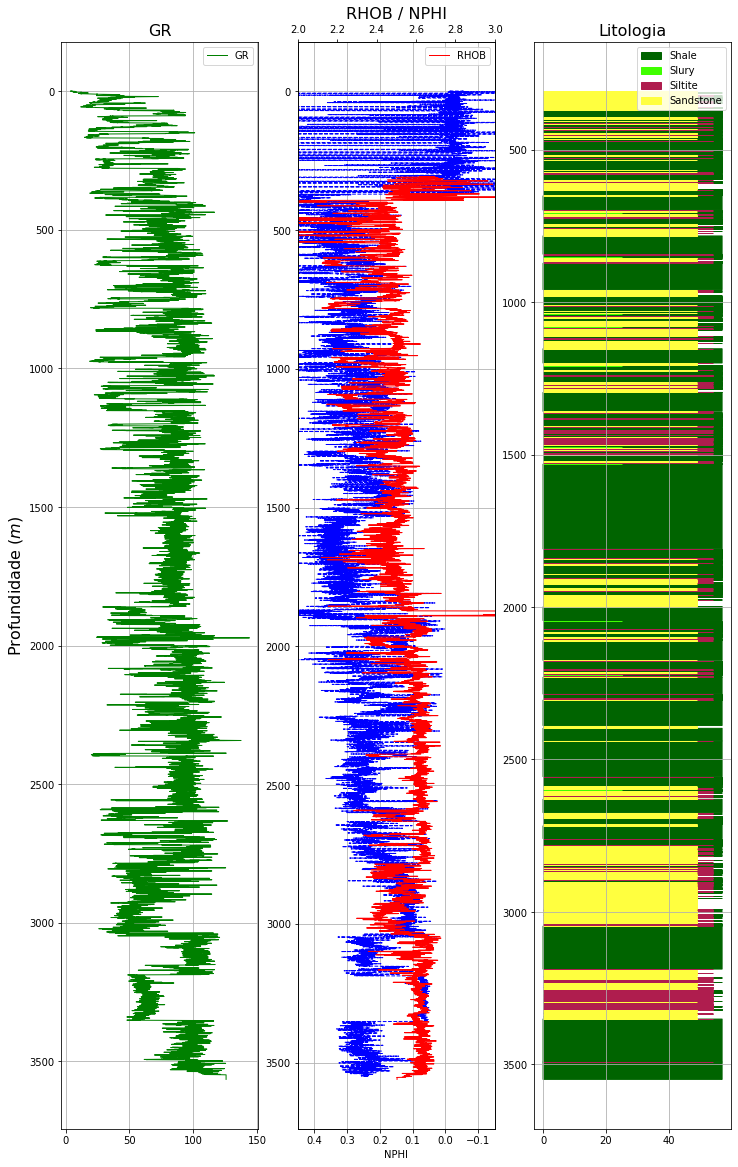

In [17]:
### Plots

fig, (ax1, ax2, ax4) = plt.subplots(1,3) # 3 tracks
fig.set_size_inches(12, 20) # Figure size | inches

#_____________________________________________________#
####GR####
ax1.plot(data['GR'],data['Depth'],'-g',linewidth = 1,label='GR')
ax1.invert_yaxis()
ax1.grid()
ax2.set_xlim([0.0, 150.0])
ax1.set_ylabel('Profundidade ($m$)', fontsize=16)
ax1.set_title('GR', fontsize=16)
ax1.legend()

#_____________________________________________________#
####NPHI####
ax2.plot(data['NPHI'], data['Depth'],'--b',linewidth = 1,label='NPHI')
ax2.set_xlim([0.45, -0.15])
ax2.set_xlabel('NPHI')
ax2.invert_yaxis()
ax2.grid()
ax2.set_title('RHOB / NPHI', fontsize=16)

#_____________________________________________________#
####RHOB####
ax3 = ax2.twiny()
ax3.plot(data['RHOB'], data['Depth'],'-r',linewidth = 1,label='RHOB')
ax3.set_xlim([2.0, 3.0])
ax3.legend()

#_____________________________________________________#
####LITHOLOGY####

ax4.fill_betweenx(data['Depth'], data['Shale']['Lithology'], step = 'post', color = 'darkgreen', label = 'Shale', interpolate=True)
ax4.fill_betweenx(data['Depth'], data['Slury']['Lithology'], step = 'post', color = '#3fff00', label = 'Slury', interpolate=True)
ax4.fill_betweenx(data['Depth'], data['Siltite']['Lithology'], step = 'post', color = '#af1d4e', label='Siltite', interpolate=True)
ax4.fill_betweenx(data['Depth'], data['Sandstone']['Lithology'], step = 'post', color = '#ffff3f', label='Sandstone', interpolate=True)

ax4.invert_yaxis()
ax4.grid()
ax4.set_title('Litologia', fontsize=16)
ax4.legend()

plt.show()

## Formação Maracangalha
#### Topo: 2527 m
#### Base: 3188 m

In [71]:
def formation_zone(data, top, base, curve='all_curves'):
    keys = list(data.keys())
    for i in range(len(keys)):
        if keys[i] == 'Depth':
            value = i
        elif keys[i] == curve:
            index = i
            
    if curve == 'all_curves':
        zone_all = []
        for k in range (len(data)):
            zone = []
            for j in range(len(data[keys[value]])):
                if data[keys[value]][j] > top and data[keys[value]][j] < base:
                    depth = data[keys[k]][j]
                    zone.append(depth)
            zone_all.append(zone)
            
        formation = {}
        for i in range(len(keys)):
            formation[keys[i]] = np.array(zone_all[i])
            
    else:
        zone = []
        for j in range(len(data[keys[value]])):
            if data[keys[value]][j] > top and data[keys[value]][j] < base:
                depth = data[keys[index]][j]
                zone.append(depth)
    
        formation = {}
        formation[keys[index]] = np.array(zone)
    
    return formation

In [72]:
#defining depth only for Maracangalha formation
top = 2527.00
base = 3188.00
formation = formation_zone(data, top, base, 'GR')

In [73]:
formation

{'GR': array([88.7177, 91.032 , 88.2027, ..., 51.5006, 48.6767, 50.058 ])}

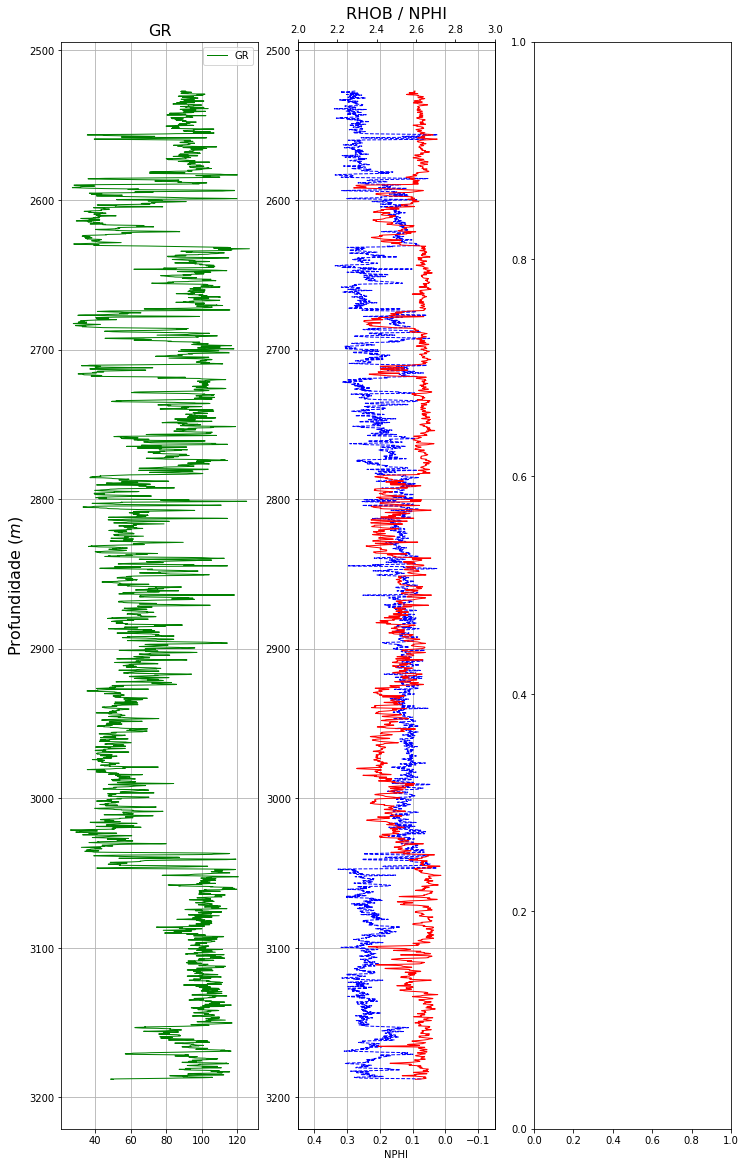

In [34]:
### Plots

fig, (ax1, ax2, ax4) = plt.subplots(1,3)
fig.set_size_inches(12, 20) # tamanho da figura | polegadas

#_____________________________________________________#
####GR####
ax1.plot(formation['GR'],formation['Depth'],'-g',linewidth = 1,label='GR')
ax1.invert_yaxis()
ax1.grid()
ax2.set_xlim([0.0, 150.0])
ax1.set_ylabel('Profundidade ($m$)', fontsize=16)
ax1.set_title('GR', fontsize=16)
ax1.legend()

#_____________________________________________________#
####NPHI####
ax2.plot(formation['NPHI'], formation['Depth'],'--b',linewidth = 1,label='NPHI')
ax2.set_xlim([0.45, -0.15])
ax2.set_xlabel('NPHI')
ax2.invert_yaxis()
ax2.grid()
ax2.set_title('RHOB / NPHI', fontsize=16)

#_____________________________________________________#
####RHOB####
ax3 = ax2.twiny()
ax3.plot(formation['RHOB'], formation['Depth'],'-r',linewidth = 1,label='RHOB')
ax3.set_xlim([2.0, 3.0])

#_____________________________________________________#
####LITHOLOGY####
#ax4.fill_betweenx(data['Depth'], data['Slury']['Lithology'], step = 'post', color = '#3fff00', label = 'Slury', interpolate=True)
#ax4.fill_betweenx(data['Depth'], data['Sandstone']['Lithology'], step = 'post', color = '#ffff3f', label='Sandstone', interpolate=True)
#ax4.fill_betweenx(data['Depth'], data['Siltite']['Lithology'], step = 'post', color = '#af1d4e', label='Siltite', interpolate=True)
#ax4.fill_betweenx(data['Depth'], data['Shale']['Lithology'], step = 'post', color = 'darkgreen', label = 'Shale', interpolate=True)
#ax4.invert_yaxis()
#ax4.grid()
#ax4.set_title('Litologia', fontsize=16)
#ax4.legend()


plt.show()

## Arenito Estatistica

In [ ]:
top = 2527.00
base = 3188.00

In [ ]:
dif = base-top

if dif % 100.0 == 0:
    interval = dif/100.0
else:
    interval = int(dif/100.0)+1.0

gr_interval_all = []
for j in range(int(interval)):
    top_interval = top+(100*j)
    base_interval = top_interval+100
    gr_interval = []
    for i, depth in enumerate(data['Depth']):
        if depth >= top_interval and depth <= base_interval and depth <= base:
            gr_interval.append(data['Sandstone']['GR'][i])
    gr_interval_all.append(gr_interval)

In [ ]:
def statistic_lithology(data, lithology, curve, top, base, step):
    dif = base-top

    if dif % step == 0:
        interval = dif/step
    else:
        interval = int(dif/step)+1.0

    curve_interval_all = []
    mean_all = []
    std_all = []
    median_all = []
    for j in range(int(interval)):
        top_interval = top+(step*j)
        base_interval = top_interval+step
        curve_interval = []
        for i, depth in enumerate(data['Depth']):
            if depth >= top_interval and depth <= base_interval and depth <= base:
                curve_interval.append(data[lithology][curve][i])
        curve_interval = np.array(curve_interval)        
        curve_interval_all.append(curve_interval)
        if curve_interval.all() == np.nan:
            mean = np.nan
            std = np.nan
            mean = np.nan
        else:
            mean = np.nanmean(np.array(curve_interval))
            std = np.nanstd(np.array(curve_interval))
            median = np.nanmedian(np.array(curve_interval))
        mean_all.append(mean)
        std_all.append(std)
        median_all.append(median)
        
    data[lithology]
        
        
    return mean_all

In [ ]:
mean_sand = statistic_lithology(data, 'Sandstone', 'GR', 2527.00, 3188.00, 50.00)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,15))

#_____________________________________________________#
####GR####
ax1.plot(gr_sand, data['Depth'], 'g', label = 'GR')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()

#_____________________________________________________#
####RHOB####
ax2.plot(rhob_sand, data['Depth'], 'r', label= 'GR')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()

#_____________________________________________________#
####NPHI####
ax3.plot(nphi_sand, data['Depth'], '--b', label = 'NPHI')
ax3.invert_yaxis()
ax3.grid()
ax3.legend()

plt.show()

## Slury Estatistica

In [ ]:
#GR, RHOB, NPHI only for slurys
gr_slury = []
rhob_slury = []
nphi_slury = []

for i in range (len(slury_plot)):
    if slury_plot[i] == 3:
        gr = data['GR'][i]
        rhob = data['RHOB'][i]
        nphi = data['NPHI'][i]
    else:
        gr = np.nan
        rhob = np.nan
        nphi = np.nan
    gr_slury.append(gr)
    rhob_slury.append(rhob) 
    nphi_slury.append(nphi)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,15))

#_____________________________________________________#
####GR####
ax1.plot(gr_slury, data['Depth'], 'g', label = 'GR')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()

#_____________________________________________________#
####RHOB####
ax2.plot(rhob_slury, data['Depth'], 'r', label= 'GR')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()

#_____________________________________________________#
####NPHI####
ax3.plot(nphi_slury, data['Depth'], '--b', label = 'NPHI')
ax3.invert_yaxis()
ax3.grid()
ax3.legend()

plt.show()

## Folhelho Estatistica

In [ ]:
#GR, RHOB, NPHI only for shale
gr_shale = []
rhob_shale = []
nphi_shale = []

for i in range (len(shale_plot)):
    if shale_plot[i] == 2:
        gr = data['GR'][i]
        rhob = data['RHOB'][i]
        nphi = data['NPHI'][i]
    else:
        gr = np.nan
        rhob = np.nan
        nphi = np.nan
    gr_shale.append(gr)
    rhob_shale.append(rhob) 
    nphi_shale.append(nphi)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,15))

#_____________________________________________________#
####GR####
ax1.plot(gr_shale, data['Depth'], 'g', label = 'GR')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()

#_____________________________________________________#
####RHOB####
ax2.plot(rhob_shale, data['Depth'], 'r', label= 'GR')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()

#_____________________________________________________#
####NPHI####
ax3.plot(nphi_shale, data['Depth'], '--b', label = 'NPHI')
ax3.invert_yaxis()
ax3.grid()
ax3.legend()

plt.show()

## Siltito Estatistica

In [ ]:
#GR, RHOB, NPHI only for siltite
gr_siltite = []
rhob_siltite = []
nphi_siltite = []

for i in range (len(siltite_plot)):
    if siltite_plot[i] == 1:
        gr = data['GR'][i]
        rhob = data['RHOB'][i]
        nphi = data['NPHI'][i]
    else:
        gr = np.nan
        rhob = np.nan
        nphi = np.nan
    gr_siltite.append(gr)
    rhob_siltite.append(rhob) 
    nphi_siltite.append(nphi)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,15))

#_____________________________________________________#
####GR####
ax1.plot(gr_siltite, data['Depth'], 'g', label = 'GR')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()

#_____________________________________________________#
####RHOB####
ax2.plot(rhob_siltite, data['Depth'], 'r', label= 'GR')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()

#_____________________________________________________#
####NPHI####
ax3.plot(nphi_siltite, data['Depth'], '--b', label = 'NPHI')
ax3.invert_yaxis()
ax3.grid()
ax3.legend()

plt.show()